In [ ]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./GP_regression_multi') # path to code
from gp_sparse_linear import GP_sparse_linear # class for Gaussian process regression
from spline_func import Spline # class for reading in repulsion spline from .skf file
from prediction_statistics2 import Prediction_Stats # class for comparing the prediction performance 
from plot_functions import visualize_training_data, plot_repulsion, plot_RMSE_vs_hyper # some plotting tools


This notebook contains an example of how to fit a GPrep potential for a given set of reference forces.

First, the reference data is processed to extract the relevant forces and pair distances:

In [36]:
! python ./GP_repulsion/GP_regression_multi/get_distances.py -c 5. -o tmp.rep reference_data.xyz 

In [38]:
# training data
training_file = 'tmp.rep'
bond_file = 'bond_dists_tmp.rep' # list of bond distances in the training file
                                 # (additional output of get_distances.py)

The GPrep code contains some visualization methods. Let's look at histograms of bond distances:

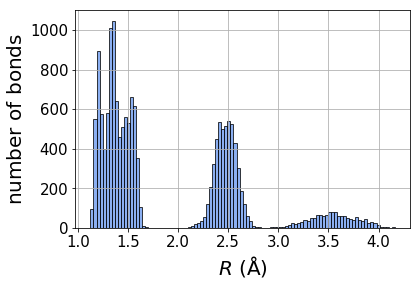

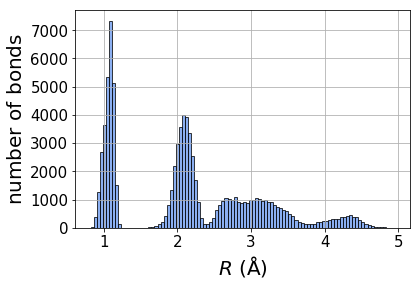

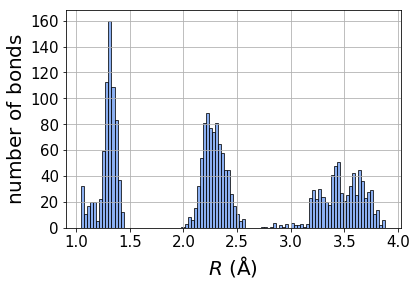

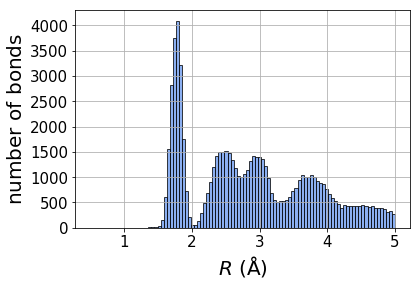

In [39]:
# histogram of bond distances
visualize_training_data(bond_file, 'C-C', figsize=None)
visualize_training_data(bond_file, 'C-O', figsize=None)
visualize_training_data(bond_file, 'C-H', figsize=None)
visualize_training_data(bond_file, 'O-O', figsize=None)
visualize_training_data(bond_file, 'O-H', figsize=None)
visualize_training_data(bond_file, 'H-H', figsize=None)

Now that we have the data, we can fit the repulsive potentials. This requires setting the hyperparameters, as detailed in the paper:

In [150]:
# the covariance function (kernel) k expresses our prior assumptions about the fit function.
# the parameters of the kernel are called hyperparameters:

# cutoff: range of the repulsive potential
# sigma : data noise (if delta = 1, then data noise to prior function variance ratio) --> prevents overfitting
# delta: prior function variance
# theta: length scale of covariance (over which length are function values similar to each other?)
# beta: exponential damping (for smoother function in the long range)
# X_pseudo: representative bond lengths

# all hyperparameters, except sigma, and the pseudo inputs are bond type specific
# and are passed in a 'bond dictionary'

sigma = 0.05
beta_global = 3.0
theta_global = 1.0

cutoff_CC = 2.0
start_CC = 1.1 # smallest bond distance in training file 
CC_dict = {'X_pseudo':np.linspace(start_CC, cutoff_CC, 20),
           'beta':beta_global,
           'theta':theta_global,
           'cutoff':cutoff_CC}

cutoff_CH = 1.7
start_CH = 0.8
CH_dict = {'X_pseudo':np.linspace(start_CH, cutoff_CH, 20),
           'beta':beta_global,
           'theta':theta_global,
           'cutoff':cutoff_CH}

cutoff_CO = 2.0
start_CO = 1.1
CO_dict = {'X_pseudo':np.linspace(start_CO, cutoff_CO, 20),
           'beta':beta_global,
           'theta':theta_global,
           'cutoff':cutoff_CO}

cutoff_OO = 2.0
start_OO = 1.0
OO_dict = {'X_pseudo':np.linspace(start_OO, cutoff_OO, 20),
           'beta':beta_global,
           'theta':theta_global,
           'cutoff':cutoff_OO}

cutoff_OH = 1.7
start_OH = 0.8
OH_dict = {'X_pseudo':np.linspace(start_OH, cutoff_OH, 20),
           'beta':beta_global,
           'theta':theta_global,
           'cutoff':cutoff_OH}

cutoff_HH = 1.2
start_HH = 0.4
HH_dict = {'X_pseudo':np.linspace(start_HH, cutoff_HH, 20),
           'beta':beta_global,
           'theta':theta_global,
           'cutoff':cutoff_HH}

bond_dict = {'C-C':CC_dict, 'C-H':CH_dict, 'C-O':CO_dict, 'O-O':OO_dict, 'O-H':OH_dict, 'H-H':HH_dict}

# kernel: function that expresses covariance between function values
kernel = 'SE_damped_cut' # Squared Exponential covariance function with damping and cutoff

# training
gp = GP_sparse_linear(bond_dict=bond_dict,
                      training_file=training_file,
                      kernel=kernel,
                      sigma=sigma,
                      rel_sigma=False)


Let's look at the potentials we fitted:

In [151]:
# load literature potential 3ob for comparison
bond_dict = {'C-C':{'skf':'PATHTO3OB/C-C.skf'},
             'C-H':{'skf':'PATHTO3OB/C-H.skf'},
             'C-O':{'skf':'PATHTO3OB/C-O.skf'},
             'O-O':{'skf':'PATHTO3OB/O-O.skf'},
             'O-H':{'skf':'PATHTO3OB/O-H.skf'},
             'H-H':{'skf':'PATHTO3OB/H-H.skf'}}
tob = Spline(bond_dict)

In [152]:
# plotting
mod_gp = {'type':'GP', 'model':gp, 'label':'GPrep', 'color':'MediumSeaGreen'}
mod_tob = {'type':'Spline', 'model':tob, 'label':'3ob', 'color':'Orange'}

mod_dict = {'gp':mod_gp, 'mio':mod_tob}

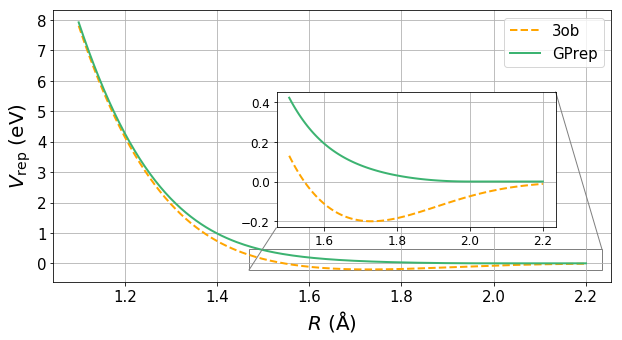

In [153]:
X_CC = np.linspace(start_CC, cutoff_CC+0.2, 200)
plot_repulsion(X_CC, 'C-C', mod_dict=mod_dict, der=0)

In [154]:
X_CO = np.linspace(start_CO, cutoff_CO+0.1, 200)
plot_repulsion(X_CO, 'C-O', mod_dict=mod_dict, der=0)

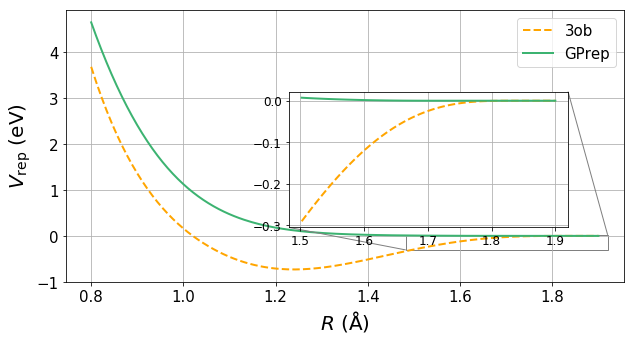

In [155]:
X_CH = np.linspace(start_CH, cutoff_CH+0.2, 200)
plot_repulsion(X_CH, 'C-H', mod_dict=mod_dict, der=0)

In [156]:
X_OH = np.linspace(start_OH, cutoff_OH+0.2, 200)
plot_repulsion(X_CC, 'O-H', mod_dict=mod_dict, der=0)

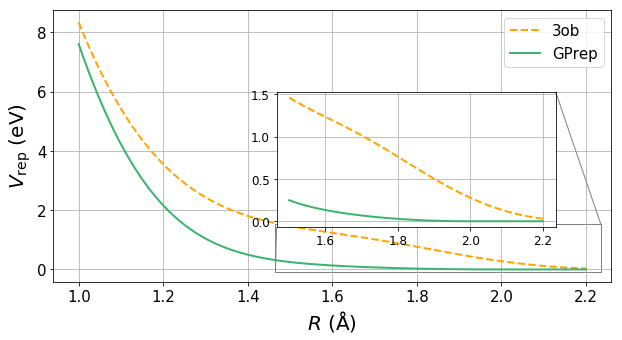

In [157]:
X_OO = np.linspace(start_OO, cutoff_OO+0.2, 200)
plot_repulsion(X_OO, 'O-O', mod_dict=mod_dict, der=0)

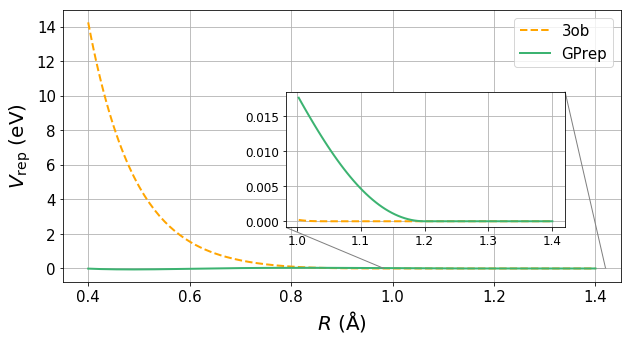

In [158]:
X_HH = np.linspace(start_HH, cutoff_HH+0.2, 200)
plot_repulsion(X_HH, 'H-H', mod_dict=mod_dict, der=0,R_min=cutoff_HH-0.2)

Finally, we can save the potentials in .skf files, which can be used with DFTB+:

In [75]:
# spline and write to .skf
gp.make_skf_spline(s0=start_CC, s1=start_CC+0.1, N=100, outputfile='C-C_GPrep_SI.skf', bond_type='C-C')
gp.make_skf_spline(s0=start_CH, s1=start_CH+0.1, N=100, outputfile='C-H_GPrep_SI.skf', bond_type='C-H')
gp.make_skf_spline(s0=start_CO, s1=start_CO+0.1, N=100, outputfile='C-O_GPrep_SI.skf', bond_type='C-O')
gp.make_skf_spline(s0=start_OO, s1=start_OO+0.1, N=100, outputfile='O-O_GPrep_SI.skf', bond_type='O-O')
gp.make_skf_spline(s0=start_OH, s1=start_OH+0.1, N=100, outputfile='O-H_GPrep_SI.skf', bond_type='O-H')
gp.make_skf_spline(s0=start_HH, s1=start_HH+0.1, N=100, outputfile='H-H_GPrep_SI.skf', bond_type='H-H')